# Kannada MNIST

## 1. Imports

In this section, we import all of the required imports for this exercise.

a. Basic imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

b. Torch imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


c. Metrics

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score

d. Memory management

In [4]:
import gc

## 2. Functions for memory management

This exercise required some memory management as I would routinely run out of GPU space on the kaggle workspace.

In [5]:
class MemoryManagement:
    @staticmethod
    def remaining_cuda_memory():
        '''
        Returns unallocated CUDA memory.
        '''
        c = torch.cuda.memory_cached(0)
        a = torch.cuda.memory_allocated(0)
        f = c-a  # free inside cache
        return f
    
    @staticmethod
    def all_allocated_items():
        '''
        Taken from https://forum.pyro.ai/t/a-clever-trick-to-debug-tensor-memory/556.
        
        Prints a list of allocated objects in cache - cpu or cuda.
        '''
        import collections, resource
        print('maxrss = {}'.format(
            resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))
        tensors = collections.Counter((str(o.device), o.dtype, tuple(o.shape))
                                      for o in gc.get_objects()
                                      if torch.is_tensor(o))
        result = []
        for line in tensors.items():
            result.append('{}\t{}'.format(*line))
        return result

In [6]:
#Test:
MemoryManagement.all_allocated_items()

maxrss = 273784


/opt/conda/lib/python3.6/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


[]

## 3. Basic analysis of data

In [7]:
validation_path = '/kaggle/input/Kannada-MNIST/Dig-MNIST.csv'
#submission_path = 'kaggle\\input\\Kannada-MNIST\\sample_submission.csv'
testing_path = '/kaggle/input/Kannada-MNIST/test.csv'
training_path = '/kaggle/input/Kannada-MNIST/train.csv'

train = pd.read_csv(training_path)
val = pd.read_csv(validation_path)

Text(0.5, 1.0, 'the mean pixel value for every pixel')

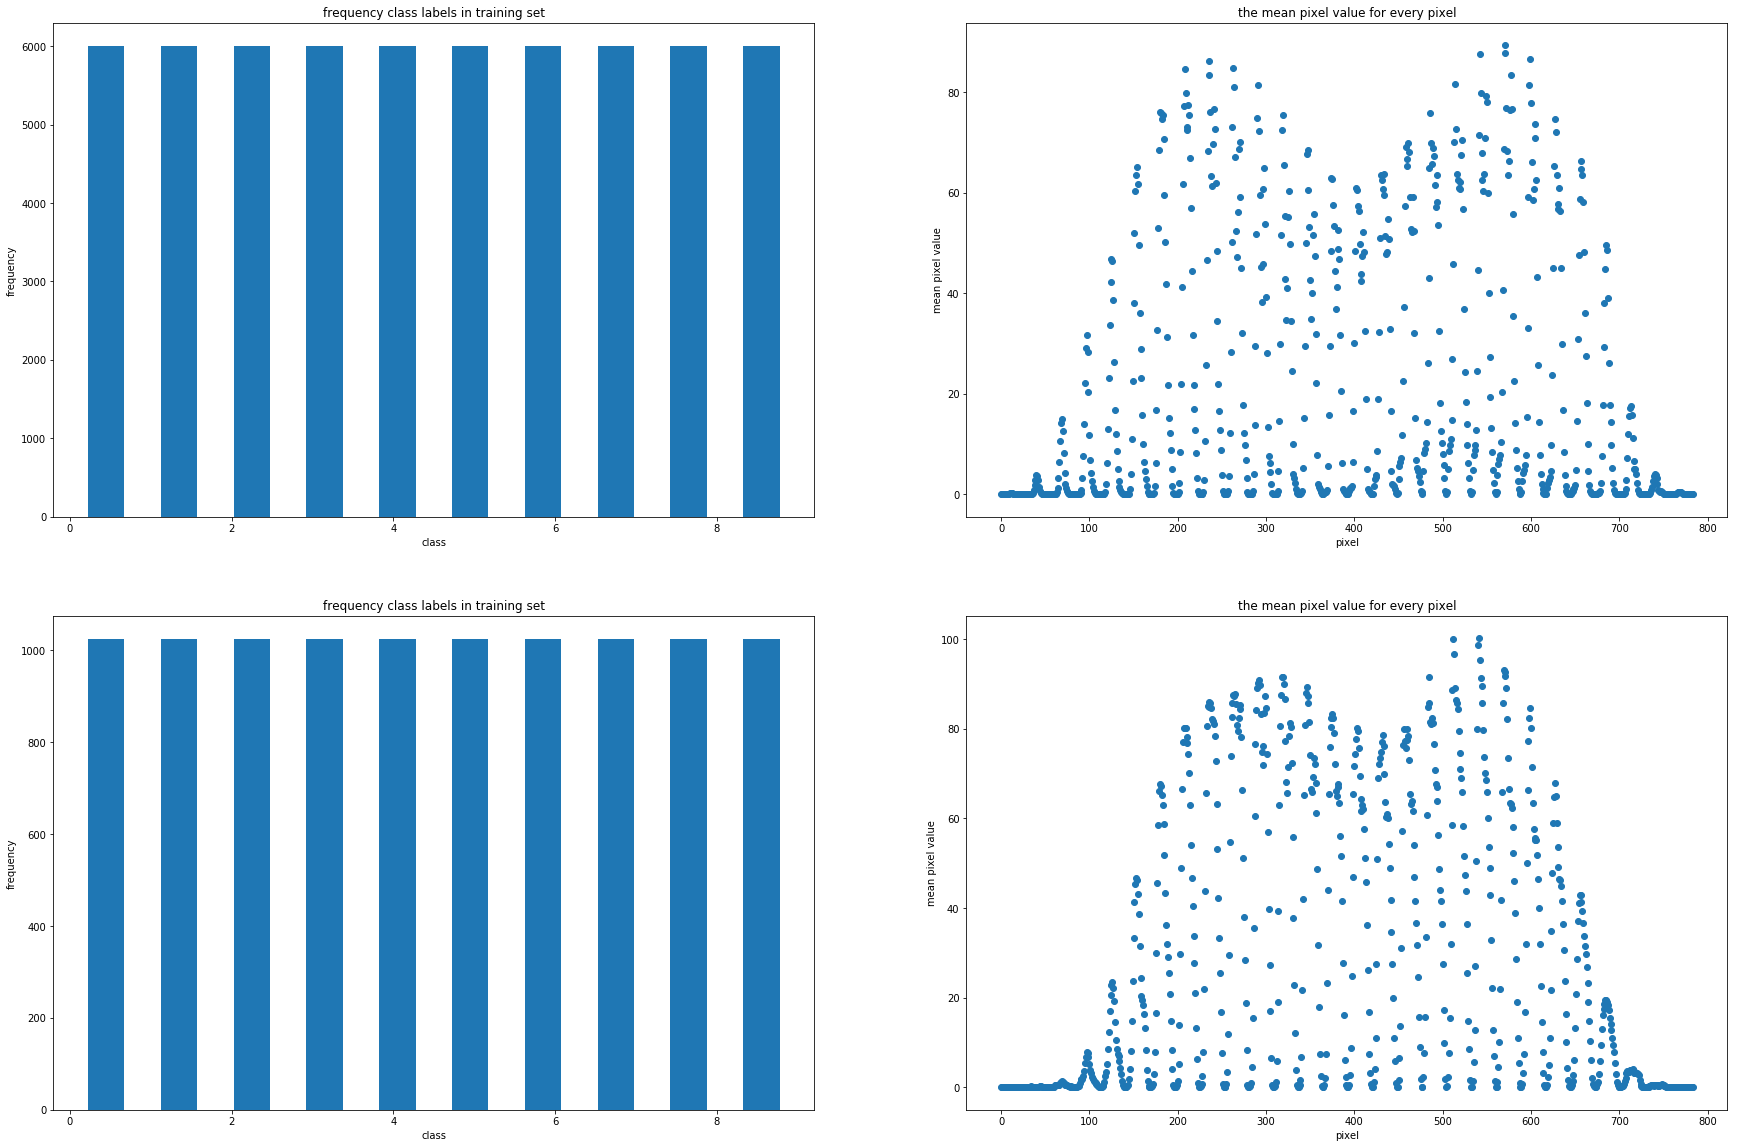

In [8]:
labels = train['label'].values
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
res = axes[0][0].hist(labels,rwidth=0.5)
axes[0][0].set_ylabel('frequency')
axes[0][0].set_xlabel('class')
axes[0][0].set_title('frequency class labels in training set')

del train['label']
axes[0][1].scatter(np.arange(784),train.mean(0))
axes[0][1].set_ylabel('mean pixel value')
axes[0][1].set_xlabel('pixel')
axes[0][1].set_title('the mean pixel value for every pixel')

labels = val['label'].values
res = axes[1][0].hist(labels,rwidth=0.5)
axes[1][0].set_ylabel('frequency')
axes[1][0].set_xlabel('class')
axes[1][0].set_title('frequency class labels in training set')

del val['label']
axes[1][1].scatter(np.arange(784),val.mean(0))
axes[1][1].set_ylabel('mean pixel value')
axes[1][1].set_xlabel('pixel')
axes[1][1].set_title('the mean pixel value for every pixel')

Text(0.5, 1.0, 'Test set')

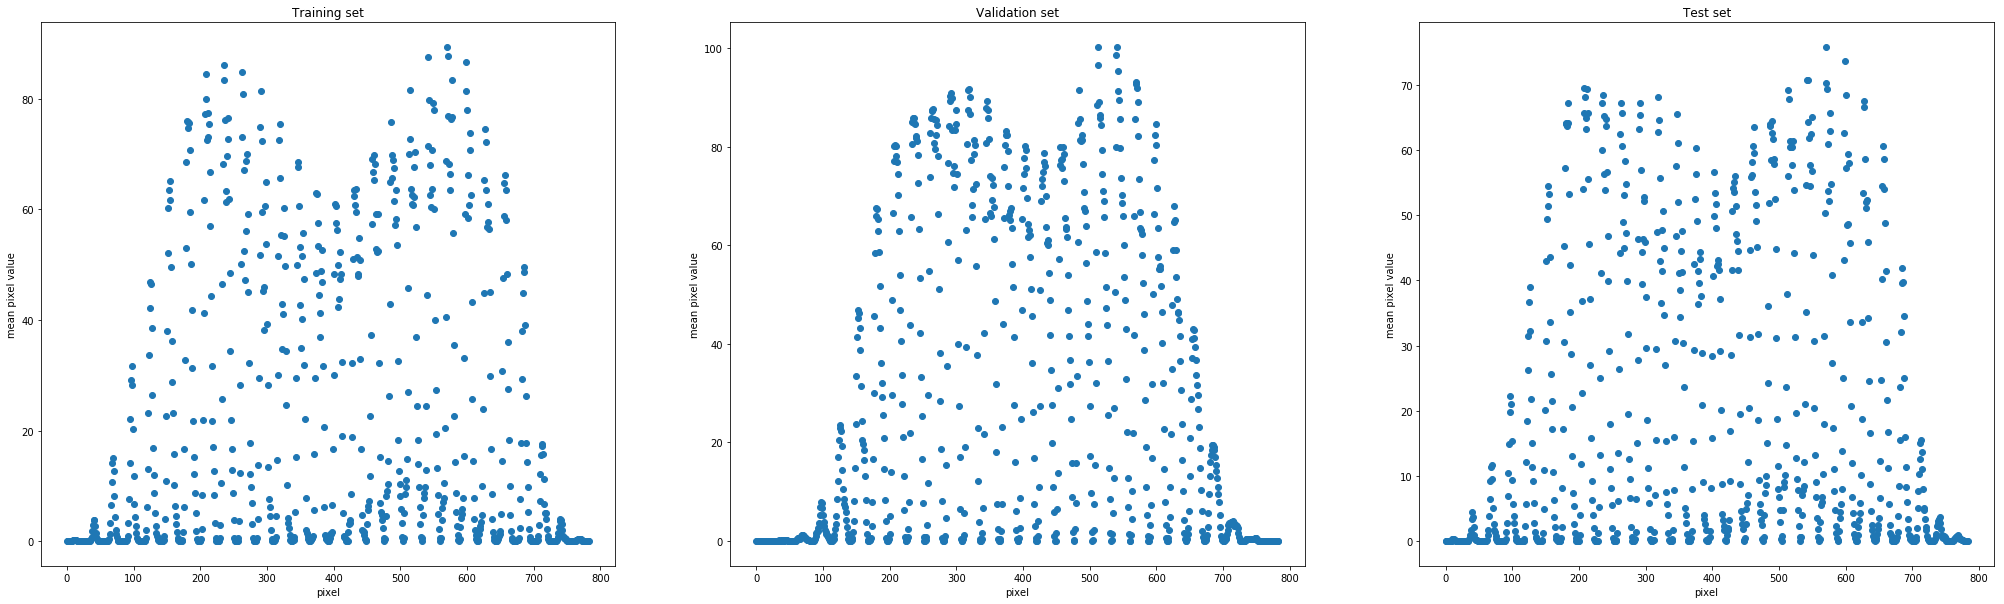

In [9]:
testing = pd.read_csv(testing_path)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(35, 10))
axes[0].scatter(np.arange(784),train.mean(0))
axes[0].set_ylabel('mean pixel value')
axes[0].set_xlabel('pixel')
axes[0].set_title('Training set')

axes[1].scatter(np.arange(784),val.mean(0))
axes[1].set_ylabel('mean pixel value')
axes[1].set_xlabel('pixel')
axes[1].set_title('Validation set')

del testing['id']
axes[2].scatter(np.arange(784),testing.mean(0))
axes[2].set_ylabel('mean pixel value')
axes[2].set_xlabel('pixel')
axes[2].set_title('Test set')

In [ ]:
training_matrix = train.values.reshape(-1,28,28)
vals_matrix = val.values.reshape(-1,28,28)
test_matrix = testing.values.reshape(-1,28,28)

#means
train_mean_surface = training_matrix.mean(0)
val_mean_surface = vals_matrix.mean(0)
test_mean_surface = test_matrix.mean(0)

#standard deviations
train_std_surface = training_matrix.std(0)
val_std_surface = vals_matrix.std(0)
test_std_surface = test_matrix.std(0)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))



im = axes[0][0].imshow(train_mean_surface)
axes[0][0].set_title('heat map of training set mean values')
im = axes[0][1].imshow(val_mean_surface)
axes[0][1].set_title('heat map of validation set mean values')
im = axes[0][2].imshow(test_mean_surface)
axes[0][2].set_title('heat map of testing set mean values')


im = axes[1][0].imshow(train_std_surface)
axes[1][0].set_title('heat map of training set std values')
im = axes[1][1].imshow(val_std_surface)
axes[1][1].set_title('heat map of validation set std values')
im = axes[1][2].imshow(test_std_surface)
axes[1][2].set_title('heat map of testing set std values')



fig.tight_layout()
plt.show()


In [ ]:
del labels,res,fig,axes,train,val
gc.collect()

From the above analysis we conclude that the statisitics of the testing data most aligns with the training data. Whilst the validation data has a fundamentally different mean and standard deviation signature.

## 5. Models

In this section, the model is created. Basic DNNs and CNNs feature extract 'units' are created and amalgamated in the 'kannada_model'.

In [ ]:
class DNN(nn.Module):
    def __init__(self,input_size, output_size, hidden_layers  = [], drop_p = 0.3):
        super(DNN, self).__init__()
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hl = len(hidden_layers)
        if self.hl!=0:
            self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
            self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
            self.output = nn.Linear(hidden_layers[-1], output_size)
        else:
            self.hidden_layers = nn.ModuleList([nn.Linear(input_size, output_size)])
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            #x = nn.BatchNorm1d(x.shape[1]).to(device)(x)
            x = self.dropout(x)
        if self.hl!=0:
            x = self.output(x)
        
        return x
    
class CNN_unit(nn.Module):
    def __init__(self, in_channel ,out_channel, kernel_size):
        super(CNN_unit, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=1, padding=0, bias=True)
        self.cnn2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=kernel_size, stride=1, padding=0, bias=True)
        self.bn = nn.BatchNorm2d(out_channel)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
        self.p = nn.Dropout(p = 0.25)
        
    def forward(self, x):
        x = self.cnn1(x)
        x = self.bn(x)
        x = F.leaky_relu(x)
        x = self.cnn2(x)
        x = self.bn(x)
        x = self.maxpool(x)
        x = self.p(x)
        x = F.relu(x)
        return x
    
class KannadaNet(nn.Module):
    def __init__(self):
        super(KannadaNet, self).__init__()
        
        #cnn layer part 1
        self.conv1 = nn.Conv2d(1,64, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        #cnn layer part 2
        self.conv2 = nn.Conv2d(64,64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.mp2 = nn.MaxPool2d(2, stride=2, padding=0)
        self.d2 = nn.Dropout2d(p=0.4)
        
        #cnn layer part 3
        self.conv3 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.mp3 = nn.MaxPool2d(2, stride=2, padding=0)
        self.d3 = nn.Dropout2d(p=0.4)
        
        #cnn layer part 4
        self.conv4 = nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.mp4 = nn.MaxPool2d(2, stride=2, padding=0)
        self.d4 = nn.Dropout2d(p=0.4)
    
    
        # fully connected layer
        self.linear1 = nn.Linear(256*3*3, 512) 
        self.dl1 = nn.Dropout(p=0.4)
        self.linear2 = nn.Linear(512,256) 
        self.dl2 = nn.Dropout(p=0.4)
        self.linear3 = nn.Linear(256,128) 
        self.dl3 = nn.Dropout(p=0.4)
        self.last_layer = nn.Linear(128,10) 
        
    def forward(self, x):
        
        #cnn layer part 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        #cnn layer part 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)       
        x = self.d2(x)
        x = self.mp2(x) 
        
        #cnn layer part 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.d3(x)
        x = self.mp3(x)
        
        #cnn layer part 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.d4(x)
        x = self.mp4(x)
        
        x = x.view(-1, 256*3*3)
        
        # fully connected layer
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dl1(x)
        
        x = self.linear2(x)
        x = F.relu(x)
        x = self.dl2(x)

        x = self.linear3(x)
        x = F.relu(x)
        x = self.dl3(x)
        
        x = self.last_layer(x)
        return F.log_softmax(x, dim=-1)





## 6. Data pre-processing

Basic data transformations are applied to the data to create a more robust dataset. A pytorch dataset object is created followed by the loading objects.

In [ ]:
IMGSIZE = 28

# Transformations for the train
trans = transforms.RandomApply(([transforms.RandomCrop(IMGSIZE),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1),shear  = 2)]), p = 0.8)

train_trans = transforms.Compose(([
    transforms.ToPILImage(),
    trans,
    transforms.ToTensor(),
]))

# Transformations for the validation & test sets
val_trans = transforms.Compose(([
    transforms.ToPILImage(),
    transforms.ToTensor()
]))

class DataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels,transforms = None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i]
        data = np.array(data).astype(np.uint8).reshape(IMGSIZE,IMGSIZE,1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

The training and validation dataloaders are created from dataset objects.

In [ ]:
validation_path = '/kaggle/input/Kannada-MNIST/Dig-MNIST.csv'
#submission_path = 'kaggle\\input\\Kannada-MNIST\\sample_submission.csv'
#testing_path = 'kaggle\\input\\Kannada-MNIST\\test.csv'
training_path = '/kaggle/input/Kannada-MNIST/train.csv'

train = pd.read_csv(training_path)
y_train = train['label'].values
del train['label']
X_train = train.values

val = pd.read_csv(validation_path)
y_val = val['label'].values
del val['label']
X_val = val.values

train_data = DataSet(X_train, y_train, train_trans)
val_data = DataSet(X_val, y_val, val_trans)

batch_size = 128
number_of_items = len(X_train)
number_of_iteration_per_epoch = int(number_of_items/batch_size)
    
train_loader = torch.utils.data.DataLoader(train_data, batch_size,True)
val_loader = torch.utils.data.DataLoader(val_data,len(X_val),False)

In [ ]:
model = KannadaNet()
print(model(train_data[0][0].view(-1,1,28,28)).shape)#

del model
gc.collect()
torch.cuda.empty_cache()

We can show some examples of how the randomly augmented data changes the data.

In [ ]:
number_of_examples = 6
fig, axes = plt.subplots(nrows=number_of_examples, ncols=2, figsize=(5, 10))
indices = np.random.randint(0,len(X_train),number_of_examples)
for i in range(0,number_of_examples):
    index = indices[i]
    axes[i][0].imshow(train_data[index][0].numpy()[0])
    axes[i][1].imshow(X_train.reshape(-1,28,28)[index])

## 7. Train data

In [ ]:
model = KannadaNet().to(device)

epochs = 15
nn_output = []

optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose = True)

def trainer(X,y,model,criterion, optimizer):
    model.zero_grad() 
    output = model(X) 
    tloss = criterion(output, y)  
    tloss.backward()  
    optimizer.step()  
    return tloss, output

for epoch in range(epochs):
    epoch_loss = 0
    train_correct = 0
    model.train()
    
    for _,data in enumerate(train_loader):
        X,y = data[0].to(device) ,data[1].to(device) 
        tloss, output = trainer(X, y, model, criterion, optimizer)
        if _%10 == 0:
            print('\r','Iteration [{}/{}] epoch train loss: {:.6f}'\
                  .format(_,number_of_iteration_per_epoch,tloss.item()),end='')
        epoch_loss += tloss.item()
        number_correct = accuracy_score(output.argmax(dim=1).detach().cpu().numpy(),y.detach().cpu().numpy(),False)
        train_correct += number_correct
    
    model.eval() 
    val_loss = 0
    val_correct = 0
    
    with torch.no_grad():
        for data in val_loader:
            X,y = data[0].to(device) ,data[1].to(device) 
            
            preds = model(X) 
            vloss = criterion(preds, y) 
            
            number_correct = accuracy_score(preds.argmax(dim=1).detach().cpu().numpy(),y.detach().cpu().numpy(),False)
            val_correct += number_correct
            val_loss += vloss.item()
    
    scheduler.step(val_loss)
    torch.save(model.state_dict(), 'checkpoint.pth')

    print(' ')
    print('Epoch [{}/{}] train loss: {:.6f} acc: {:.2f} - valid loss: {:.6f} acc: {:.2f}'
        .format(epoch+1,epochs,epoch_loss/len(train_loader.dataset),train_correct/len(train_loader.dataset)*100,
                     val_loss/len(val_loader.dataset), val_correct/len(val_loader.dataset)*100))

## 9. Submit results

In [ ]:
model.eval()
submission_path = '/kaggle/input/Kannada-MNIST/test.csv'
submission = pd.read_csv(submission_path)
submission1 = submission.drop('id',axis = 1).values
submission1 = np.array(submission1).astype(np.uint8)#.reshape(-1,28,28,1)
submission1 = val_trans(submission1).view(-1,1,28,28).to(device)
out = model(submission1)
values, indices = out.max(1)
pred = pd.DataFrame(indices.cpu().detach().numpy(), columns=['label'])
pred['id'] = submission['id']
pred

In [ ]:
pred.to_csv('submission.csv', index=False, columns=['id', 'label'])